## Target number of units

In [1]:
from sqlalchemy import create_engine
from pysandag.database import get_connection_string
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

In [2]:
db_connection_string = get_connection_string('..\data\config.yml', 'mssql_db')
mssql_engine = create_engine(db_connection_string)

Target units from regionwide forecast

In [3]:
# Target number of units: units needed
units_needed_sql = '''
SELECT sum(housing_units_add) as housing_units_to_add
FROM [isam].[economic_output].[urbansim_housing_units]'''
units_needed_df =  pd.read_sql(units_needed_sql, mssql_engine)
units_needed = int(units_needed_df.values)

Capacity from parcel update 2017

In [4]:
# capacity
parcel_update_2017_sql = '''
    SELECT	parcelid_2015 as parcel_id, p.mgra_id, p.jurisdiction_id, 
            p.luz_id, p.site_id, cap_remaining_new AS capacity_base_yr, 
            du_2017 AS residential_units, 
            0 as partial_build
       FROM urbansim.urbansim.parcel_update_2017 update2017
       JOIN urbansim.urbansim.parcel p
         ON p.parcel_id = update2017.parcelid_2015
      WHERE cap_remaining_new > 0 and jurisdiction_id NOT IN (14,19) and site_id IS NULL
'''
update_2017_df =  pd.read_sql(parcel_update_2017_sql, mssql_engine)
update_2017_capacity = int(update_2017_df.capacity_base_yr.sum())
# print(update_2017_capacity)

Capacity from city and county - not yet in parcel update 2017

In [5]:
# capacity for city and county - not in parcel update 2017
parcel_city_and_county_sql = '''
    SELECT	parcel_id, p.mgra_id, p.jurisdiction_id, 
            p.luz_id, p.site_id, capacity AS capacity_base_yr, 
            du AS residential_units, 
            0 as partial_build
       FROM urbansim.urbansim.parcel p
      WHERE capacity > 0 and jurisdiction_id IN (14,19) and site_id IS NULL
'''
city_county_capacity_parcel_df =  pd.read_sql(parcel_city_and_county_sql, mssql_engine)
city_county_capacity = int(city_county_capacity_parcel_df.capacity_base_yr.sum())
# print(city_county_capacity)

Scheduled development capacity

In [6]:
# capacity from sched dev
sched_dev_sql = '''
    SELECT scenario, parcel_id, yr, site_id, 
           res_units, job_spaces, households, jobs
      FROM urbansim.urbansim.scheduled_development_do_not_use
     WHERE scenario = 1 and yr > 2016
'''
sched_dev_df =  pd.read_sql(sched_dev_sql, mssql_engine)
sched_dev_capacity = int(sched_dev_df.res_units.sum())
# print(sched_dev_capacity)

In [7]:
capacity = update_2017_capacity + city_county_capacity + sched_dev_capacity

# Target

In [8]:
print("Target units to add: {:,}".format(units_needed))

Target units to add: 396,354


# Capacity

In [9]:
print("Capacity: {:,}".format(capacity))

Capacity: 364,170


# Remaining

In [10]:
print("Remaining units: {:,}".format(capacity - units_needed))

Remaining units: -32,184


# Target units 2017

In [11]:
housing_unit_sql = '''select  yr,
    housing_units1, households,housing_units_add 
    from [isam].[economic_output].[urbansim_housing_units]'''
hu_df =  pd.read_sql(housing_unit_sql, mssql_engine)
hu_df['total_housing_units_add'] = hu_df.housing_units_add.cumsum()

In [12]:
units_to_add_2017 = int(hu_df.loc[hu_df.yr == 2017].housing_units_add.values[0])
print("Target units to add 2017: {:,}".format(units_to_add_2017))

Target units to add 2017: 10,947


# Existing du 2017 urbansim.parcel_update_2017

In [13]:
existing_du_sql = '''
  select sum(du_2017) 
  from [urbansim].[urbansim].[parcel_update_2017]'''
existing_du_df =  pd.read_sql(existing_du_sql, mssql_engine)
existing_du = int(existing_du_df.values)

In [14]:
print("Existing du 2017 from urbansim.parcel_update_2017: {:,}".format(existing_du))

Existing du 2017 from urbansim.parcel_update_2017: 1,192,416


# Calculate number of housing units: existing du + target units

In [15]:
housing_units_end_of_2017 = units_to_add_2017 + existing_du
print("Housing units at end of 2017: {:,}".format(housing_units_end_of_2017))

Housing units at end of 2017: 1,203,363


# Database number of housing units [isam].[economic_output].[urbansim_housing_units]

In [16]:
hu_df_2017 = int(hu_df.loc[hu_df.yr == 2017].housing_units1.values[0])
print("Housing units at end of 2017 from database table: {:,}".format(hu_df_2017))

Housing units at end of 2017 from database table: 1,203,896


#  <span style="color:red">Difference between database table and calculated units </span>

In [17]:
diff_hu_2017 = hu_df_2017 - housing_units_end_of_2017
print("Difference between database and calculation for 2017 housing units: {:,}".format(diff_hu_2017))

Difference between database and calculation for 2017 housing units: 533


# Plot (note: increase 2026 and 2027)

In [18]:
hu_df['capacity'] = capacity

In [19]:
hu_df['remaining_capacity'] = hu_df['capacity'] - hu_df['total_housing_units_add'] 

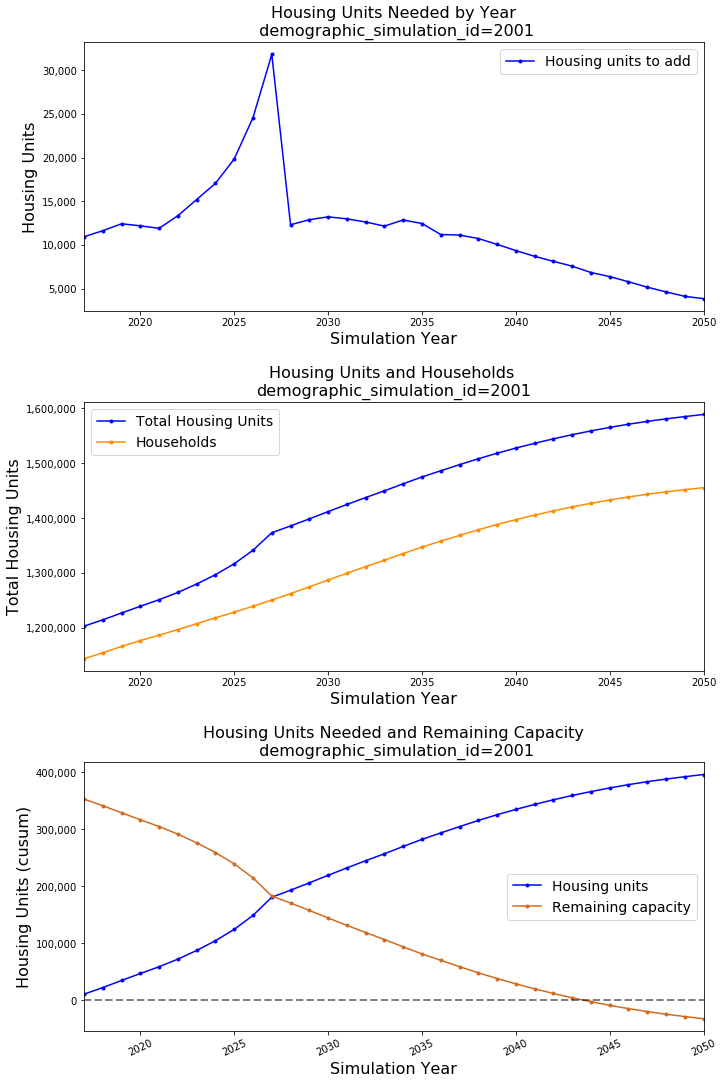

In [20]:
fig, axes = plt.subplots(3, 1)


plot_df = hu_df[['yr','housing_units_add']].copy()
plot_df.rename(columns = {'housing_units_add': 'Housing units to add'}, inplace=True)
plot_df.set_index('yr',inplace=True)
plot_df.plot(style='.-',ax=axes.flat[0],figsize=(10,5),color='b')

plot_df = hu_df[['yr','total_housing_units_add','households']].copy()
plot_df.set_index('yr',inplace=True)
plot_df['Total Housing Units'] = existing_du + plot_df['total_housing_units_add']
plot_df.rename(columns = {'households': 'Households'}, inplace=True)
del  plot_df['total_housing_units_add']
plot_df.plot(style='.-',ax=axes.flat[1],figsize=(10,10),color=['darkorange','b'])

plot_df = hu_df[['yr','total_housing_units_add','remaining_capacity']].copy()
plot_df.set_index('yr',inplace=True)
plot_df.rename(columns = {'total_housing_units_add': 'Housing units'}, inplace=True)
plot_df.rename(columns = {'remaining_capacity': 'Remaining capacity'}, inplace=True)
plot_df.plot(style='.-',ax=axes.flat[2],figsize=(10,15),color=['b','chocolate'])
plt.axhline(y=0,color='black', lw=2, alpha=0.5,linestyle='--')
# format
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)

axes.flat[0].set_xlabel("Simulation Year",size =16)
axes.flat[0].set_ylabel("Housing Units",size =16)
axes.flat[0].set_title('Housing Units Needed by Year\n demographic_simulation_id=2001',size=16) 
axes.flat[0].yaxis.set_major_formatter(tick) 
axes.flat[0].legend(fontsize=14)

# change order of legend in second plot
axes.flat[1].set_xlabel("Simulation Year",size=16)
axes.flat[1].set_ylabel("Total Housing Units",size =16)
axes.flat[1].set_title('Housing Units and Households \ndemographic_simulation_id=2001',size=16) 
axes.flat[1].yaxis.set_major_formatter(tick) 
handles, labels = axes.flat[1].get_legend_handles_labels()
zipped = zip(labels,handles)
zipped.sort(key = lambda t: t[0],reverse=True)
labels, handles = zip(*zipped)
axes.flat[1].legend(handles, labels,fontsize=14)
# axes.flat[1].legend(fontsize=14)

axes.flat[2].set_xlabel("Simulation Year",size =16)
axes.flat[2].set_ylabel("Housing Units (cusum)",size =16)
axes.flat[2].set_title('Housing Units Needed and Remaining Capacity\n demographic_simulation_id=2001',size=16) 
axes.flat[2].yaxis.set_major_formatter(tick) 
axes.flat[2].legend(fontsize=14)

plt.xticks(rotation=25)
plt.tight_layout(pad=0.5, w_pad=0.6, h_pad=2)



plt.show()
fig.savefig('Demographic_simulation_2001.png', format='png', dpi=300)

# Previous Version:

### Capacity

In [21]:
parcels_capacity_sql = '''
SELECT  SUM(capacity) AS capacity_parcels
FROM urbansim.urbansim.parcel where capacity > 0
'''
parcel_capacity_df =  pd.read_sql(parcels_capacity_sql, mssql_engine)
parcel_capacity = int(parcel_capacity_df.values)

In [22]:
print("Original capacity: {:,}".format(parcel_capacity))

Original capacity: 363,378


In [23]:
print("Parcel update 2017 capacity: {:,}".format(capacity))

Parcel update 2017 capacity: 364,170


In [24]:
print("Capacity difference: update 2017 minus original capacity from parcel table: {:,}".
      format(capacity-parcel_capacity))

Capacity difference: update 2017 minus original capacity from parcel table: 792


### Dwelling units

In [25]:
buildings_sql = '''
SELECT  SUM(COALESCE(residential_units,0)) AS residential_units
FROM urbansim.urbansim.building
'''

In [26]:
du_df =  pd.read_sql(buildings_sql, mssql_engine)

In [27]:
du = int(du_df.values)

In [28]:
print("Existing dwelling units: {:,}".format(du))

Existing dwelling units: 1,183,211


### Households 2050

In [29]:
household_sql = '''
  SELECT sum(hh) AS hh
  FROM isam.demographic_output.summary
  WHERE sim_id = 1004 and yr = 2050
  '''

In [30]:
hh_df =  pd.read_sql(household_sql, mssql_engine)

In [31]:
hh = int(hh_df.values)

In [32]:
print("Number of households 2050: {:,}".format(hh))

Number of households 2050: 1,476,038


### Target number of units for region

In [33]:
target_for_region = hh - du

In [34]:
print("Target for region: {:,}".format(target_for_region))

Target for region: 292,827


# Map with folium

In [35]:
import folium

In [36]:
m = folium.Map(location=[32.7157,  -117.1611])

In [37]:
m